In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import shuffle
from sklearn.decomposition import PCA

# 공통 Raman Shift 정의 (모든 데이터셋에서 사용할 기준)
COMMON_RAMAN_SHIFT = np.linspace(100, 3000, num=1500)  # 100~3000cm⁻¹ 구간을 1500개 포인트로 보간

# 데이터 로드 함수 (보간 추가)
def load_raman_data(folder_path, isMicroalgae):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".txt")]
    data_list = []  
    labels = []  
    for file in all_files:
        df = pd.read_csv(file, sep="\t", header=None, names=["Raman_Shift", "Intensity"])
        df["Raman_Shift"] = pd.to_numeric(df["Raman_Shift"], errors='coerce')
        df["Intensity"] = pd.to_numeric(df["Intensity"], errors='coerce')
        df = df.dropna().sort_values(by="Raman_Shift")
        df["Intensity"] = df["Intensity"].ffill().bfill().fillna(0)
        interpolated = np.interp(COMMON_RAMAN_SHIFT, df["Raman_Shift"], df["Intensity"])
        data_list.append(interpolated)
        labels.append(1 if isMicroalgae else 0)  
    return np.array(data_list), np.array(labels)

# 데이터 로드
Cu1_data_path = "Data/CO2RR Raman Data/Cu/Cu 1"  
Cu2_data_path = "Data/CO2RR Raman Data/Cu/Cu 2"
Cu3_data_path = "Data/CO2RR Raman Data/Cu/Cu 4"
Cu4_data_path = "Data/CO2RR Raman Data/Cu/Cu 5"
CuM_data_path = "Data/CO2RR Raman Data/CO2RR Raman Data/CuNCs-Microalgae"

X1, Y1 = load_raman_data(Cu1_data_path, False)
X2, Y2 = load_raman_data(Cu2_data_path, False)
X3, Y3 = load_raman_data(Cu3_data_path, False)
X4, Y4 = load_raman_data(Cu4_data_path, False)
X5, Y5 = load_raman_data(CuM_data_path, True)

# 모든 데이터를 수직으로 연결
X = np.vstack([X1, X2, X3, X4, X5])  
Y = np.hstack([Y1, Y2, Y3, Y4, Y5])  

# 데이터 섞기
#X, Y = shuffle(X, Y, random_state=42)

# PCA 적용하여 Feature Selection 수행
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X)

# 데이터 정규화
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_pca)

# 데이터 차원 확장 (CNN 입력 차원에 맞게 변환)
X_scaled = np.expand_dims(X_scaled, axis=-1)

# 데이터셋 분할
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42, stratify=Y)

# CNN 모델 구축
model = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    Conv1D(64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.02)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2, strides=1, padding='same'),
    Dropout(0.4),
    
    Conv1D(128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.02)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2, strides=1, padding='same'),
    Dropout(0.5),
    
    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.02)),
    Dropout(0.5),
    
    Dense(1, activation='sigmoid')
])

# EarlyStopping 추가
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# 모델 학습
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=32, callbacks=[early_stopping])

# 최종 학습 결과 출력
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")

Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.4877 - loss: 5.3169 - val_accuracy: 0.3882 - val_loss: 4.5507
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5229 - loss: 4.9858 - val_accuracy: 0.3882 - val_loss: 4.4241
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5529 - loss: 4.7346 - val_accuracy: 0.3882 - val_loss: 4.3033
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5688 - loss: 4.4684 - val_accuracy: 0.5604 - val_loss: 4.1854
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5567 - loss: 4.3592 - val_accuracy: 0.8638 - val_loss: 4.0715
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5777 - loss: 4.2434 - val_accuracy: 0.9100 - val_loss: 3.9638
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5498 - loss: 4.0721 - val_accuracy: 0.9460 - val_loss: 3.8592
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5585 - loss: 3.9919 - val_accuracy: 0.8329 - 

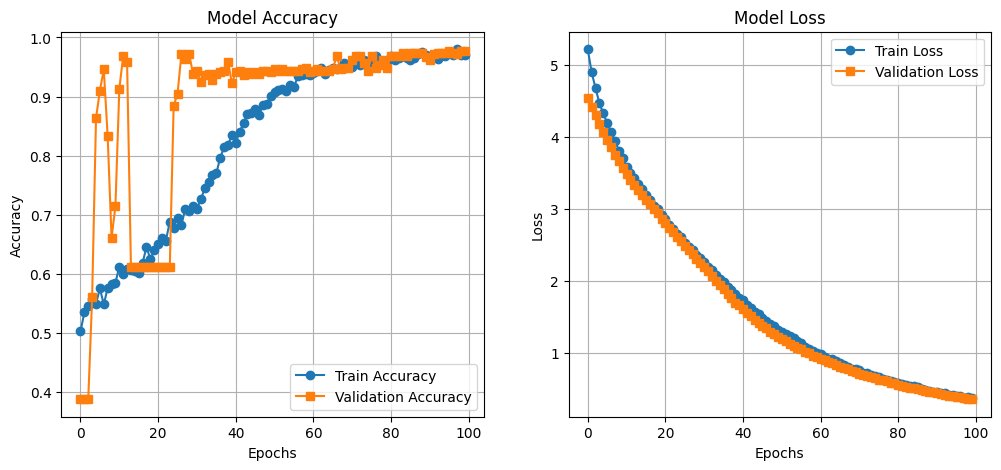

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 


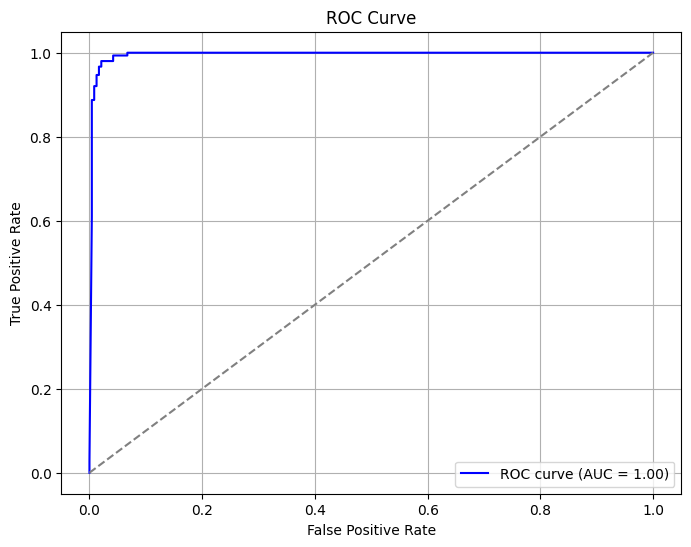

In [2]:

# 학습 정확도 및 손실 그래프
plt.figure(figsize=(12, 5))

# 정확도 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid()

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.grid()

plt.show()

# ROC Curve 및 AUC 계산
Y_pred_prob = model.predict(X_test)
fpr, tpr, _ = roc_curve(Y_test, Y_pred_prob)
roc_auc = auc(fpr, tpr)

# ROC Curve 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()



In [11]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import shuffle
from sklearn.decomposition import PCA

# 공통 Raman Shift 정의 (모든 데이터셋에서 사용할 기준)
COMMON_RAMAN_SHIFT = np.linspace(100, 3000, num=1500)  # 100~3000cm⁻¹ 구간을 1500개 포인트로 보간

# 데이터 로드 함수 (보간 추가)
def load_raman_data(folder_path, isMicroalgae):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".txt")]
    data_list = []  
    labels = []  
    for file in all_files:
        df = pd.read_csv(file, sep="\t", header=None, names=["Raman_Shift", "Intensity"])
        df["Raman_Shift"] = pd.to_numeric(df["Raman_Shift"], errors='coerce')
        df["Intensity"] = pd.to_numeric(df["Intensity"], errors='coerce')
        df = df.dropna().sort_values(by="Raman_Shift")
        df["Intensity"] = df["Intensity"].ffill().bfill().fillna(0)
        interpolated = np.interp(COMMON_RAMAN_SHIFT, df["Raman_Shift"], df["Intensity"])
        data_list.append(interpolated)
        labels.append(1 if isMicroalgae else 0)  
    return np.array(data_list), np.array(labels)

# 데이터 로드
Cu1_data_path = "Data/CO2RR Raman Data/CO2RR Raman Data/CuS"  
CuM_data_path = "Data/CO2RR Raman Data/CO2RR Raman Data/CuS-Microalgae"

X1, Y1 = load_raman_data(Cu1_data_path, False)
X2, Y2 = load_raman_data(CuM_data_path, True)

# 모든 데이터를 수직으로 연결
X = np.vstack([X1, X2])  
Y = np.hstack([Y1, Y2])  

# 데이터셋 분할
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

# CNN 모델 구축
model = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    Conv1D(64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.02)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2, strides=1, padding='same'),
    Dropout(0.4),
    
    Conv1D(128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.02)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2, strides=1, padding='same'),
    Dropout(0.5),
    
    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.02)),
    Dropout(0.5),
    
    Dense(1, activation='sigmoid')
])

# EarlyStopping 추가
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# 모델 학습
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=5, batch_size=32, callbacks=[early_stopping])

# 최종 학습 결과 출력
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")

Epoch 1/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 30s 689ms/step - accuracy: 0.8500 - loss: 5.1084 - val_accuracy: 0.9808 - val_loss: 4.2058
Epoch 2/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 27s 665ms/step - accuracy: 0.9968 - loss: 3.9520 - val_accuracy: 0.9840 - val_loss: 3.7862
Epoch 3/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 27s 664ms/step - accuracy: 1.0000 - loss: 3.5848 - val_accuracy: 0.9904 - val_loss: 3.3845
Epoch 4/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 27s 662ms/step - accuracy: 0.9963 - loss: 3.2761 - val_accuracy: 1.0000 - val_loss: 3.0519
Epoch 5/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 27s 665ms/step - accuracy: 0.9996 - loss: 2.9918 - val_accuracy: 0.9840 - val_loss: 2.8877
Final Training Accuracy: 0.9992
Final Validation Accuracy: 0.9840
Final Training Loss: 2.9323
Final Validation Loss: 2.8877


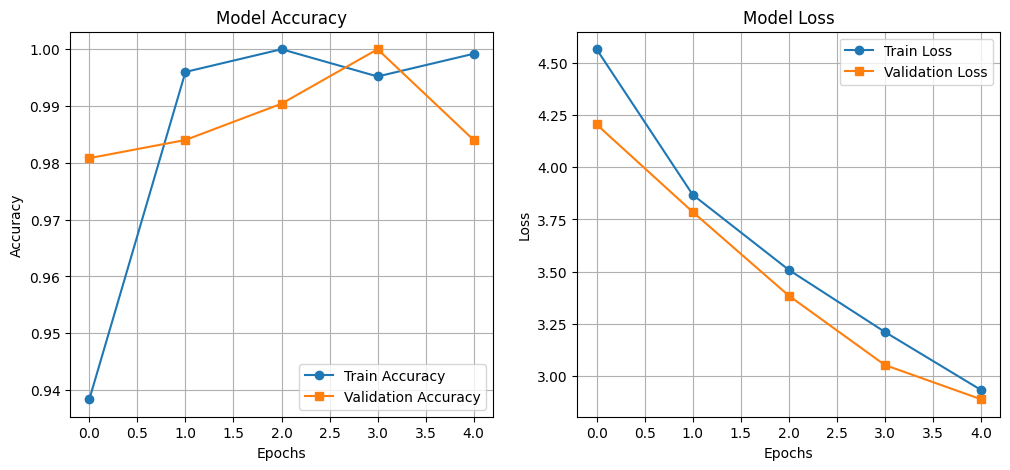

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step 


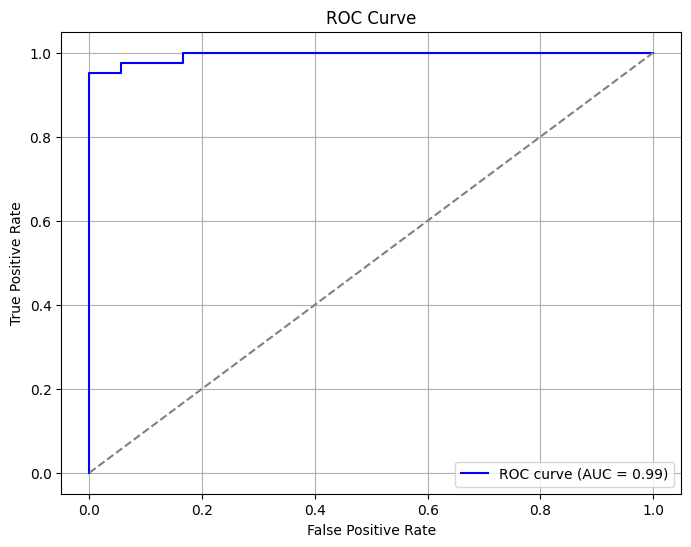

In [12]:

# 학습 정확도 및 손실 그래프
plt.figure(figsize=(12, 5))

# 정확도 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid()

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.grid()

plt.show()

# ROC Curve 및 AUC 계산
Y_pred_prob = model.predict(X_test)
fpr, tpr, _ = roc_curve(Y_test, Y_pred_prob)
roc_auc = auc(fpr, tpr)

# ROC Curve 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

